# BraTS 2021 - Brain Tumor Segmentation Dataset

The BraTS 2021 dataset is a publicly available collection of multi-modal brain MRI scans, primarily designed for brain tumor segmentation tasks.

Each patient’s data includes four MRI modalities:

* FLAIR – highlights regions of edema (swelling) in the brain.

* T1 – structural imaging, provides anatomical detail.

* T1CE – T1 with contrast enhancement, helps highlight active tumor regions.

* T2 – sensitive to water content, useful for detecting edema and tumor boundaries.

Alongside the MRI scans, segmentation masks are provided, labeling background and tumor regions:

* Background (0)

* Necrotic and non-enhancing tumor core (1)

* Edema (2)

* Enhancing tumor (4)

### 1. Dataset Overview

In [42]:
import os, random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

root_dir = "./data/BraTS2021_Training_Data"
dataset = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f)) and not f.startswith(".")]

slice_counts = []
tumor_slices = 0
bg_slices = 0
tumor_voxels = []

for case in dataset:
    seg = nib.load(os.path.join(root_dir, case, f"{case}_seg.nii.gz")).get_fdata()
    slices_with_tumor = np.sum(np.any(seg > 0, axis=(0,1)))
    slice_counts.append(seg.shape[2])
    tumor_slices += slices_with_tumor
    bg_slices += seg.shape[2] - slices_with_tumor
    tumor_voxels.extend([np.sum(seg[:,:,z]>0) for z in range(seg.shape[2]) if np.any(seg[:,:,z]>0)])

print(f"Total patients: {len(dataset)}")
print(f"Total slices: {sum(slice_counts)}")
print(f"Tumor slices: {tumor_slices} ({tumor_slices/sum(slice_counts)*100:.1f}%)")
print(f"Background-only slices: {bg_slices} ({bg_slices/sum(slice_counts)*100:.1f}%)")


Total patients: 1251
Total slices: 193905
Tumor slices: 81437 (42.0%)
Background-only slices: 112468 (58.0%)


### 2. Random Slice Visualization

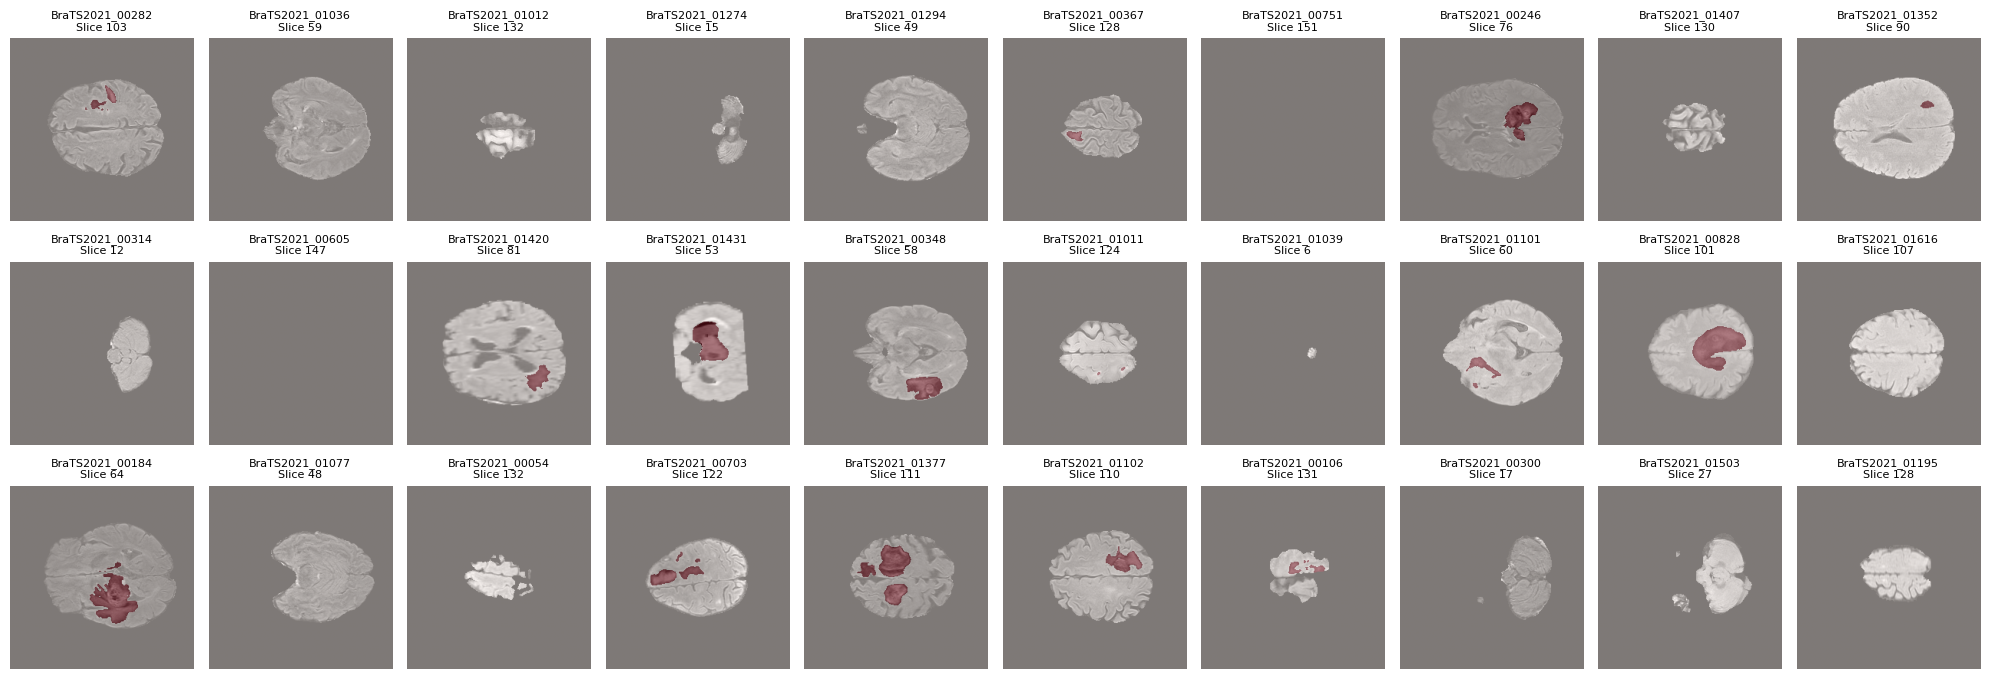

In [132]:
fig, axs = plt.subplots(3, 10, figsize=(20, 7))
random_indices = random.sample(range(len(dataset)*155), 30)

for i, idx in enumerate(random_indices):
    case_idx = idx // 155
    z = idx % 155
    case = dataset[case_idx]
    
    flair = nib.load(os.path.join(root_dir, case, f"{case}_flair.nii.gz")).get_fdata()[:,:,z]
    seg = nib.load(os.path.join(root_dir, case, f"{case}_seg.nii.gz")).get_fdata()[:,:,z]
    
    row, col = i // 10, i % 10
    axs[row, col].imshow(flair, cmap='gray')
    axs[row, col].imshow(seg>0, cmap='Reds', alpha=0.5)
    axs[row, col].set_title(f"{case}\nSlice {z}", fontsize=8)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()


### 3. MRI Modalities and Shapes

In [ ]:
cases = sorted([
    c for c in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, c)) and not c.startswith(".")
])

modalities = ["t1", "t1ce", "t2", "flair"]
shapes = {m: set() for m in modalities}

for case in cases:
    for m in modalities:
        img = nib.load(os.path.join(root_dir, case, f"{case}_{m}.nii.gz")).get_fdata()
        shapes[m].add(img.shape)

print("\nUnique shapes per modality:")
for m in modalities:
    print(m, shapes[m])


Unique shapes per modality:
t1 {(240, 240, 155)}
t1ce {(240, 240, 155)}
t2 {(240, 240, 155)}
flair {(240, 240, 155)}


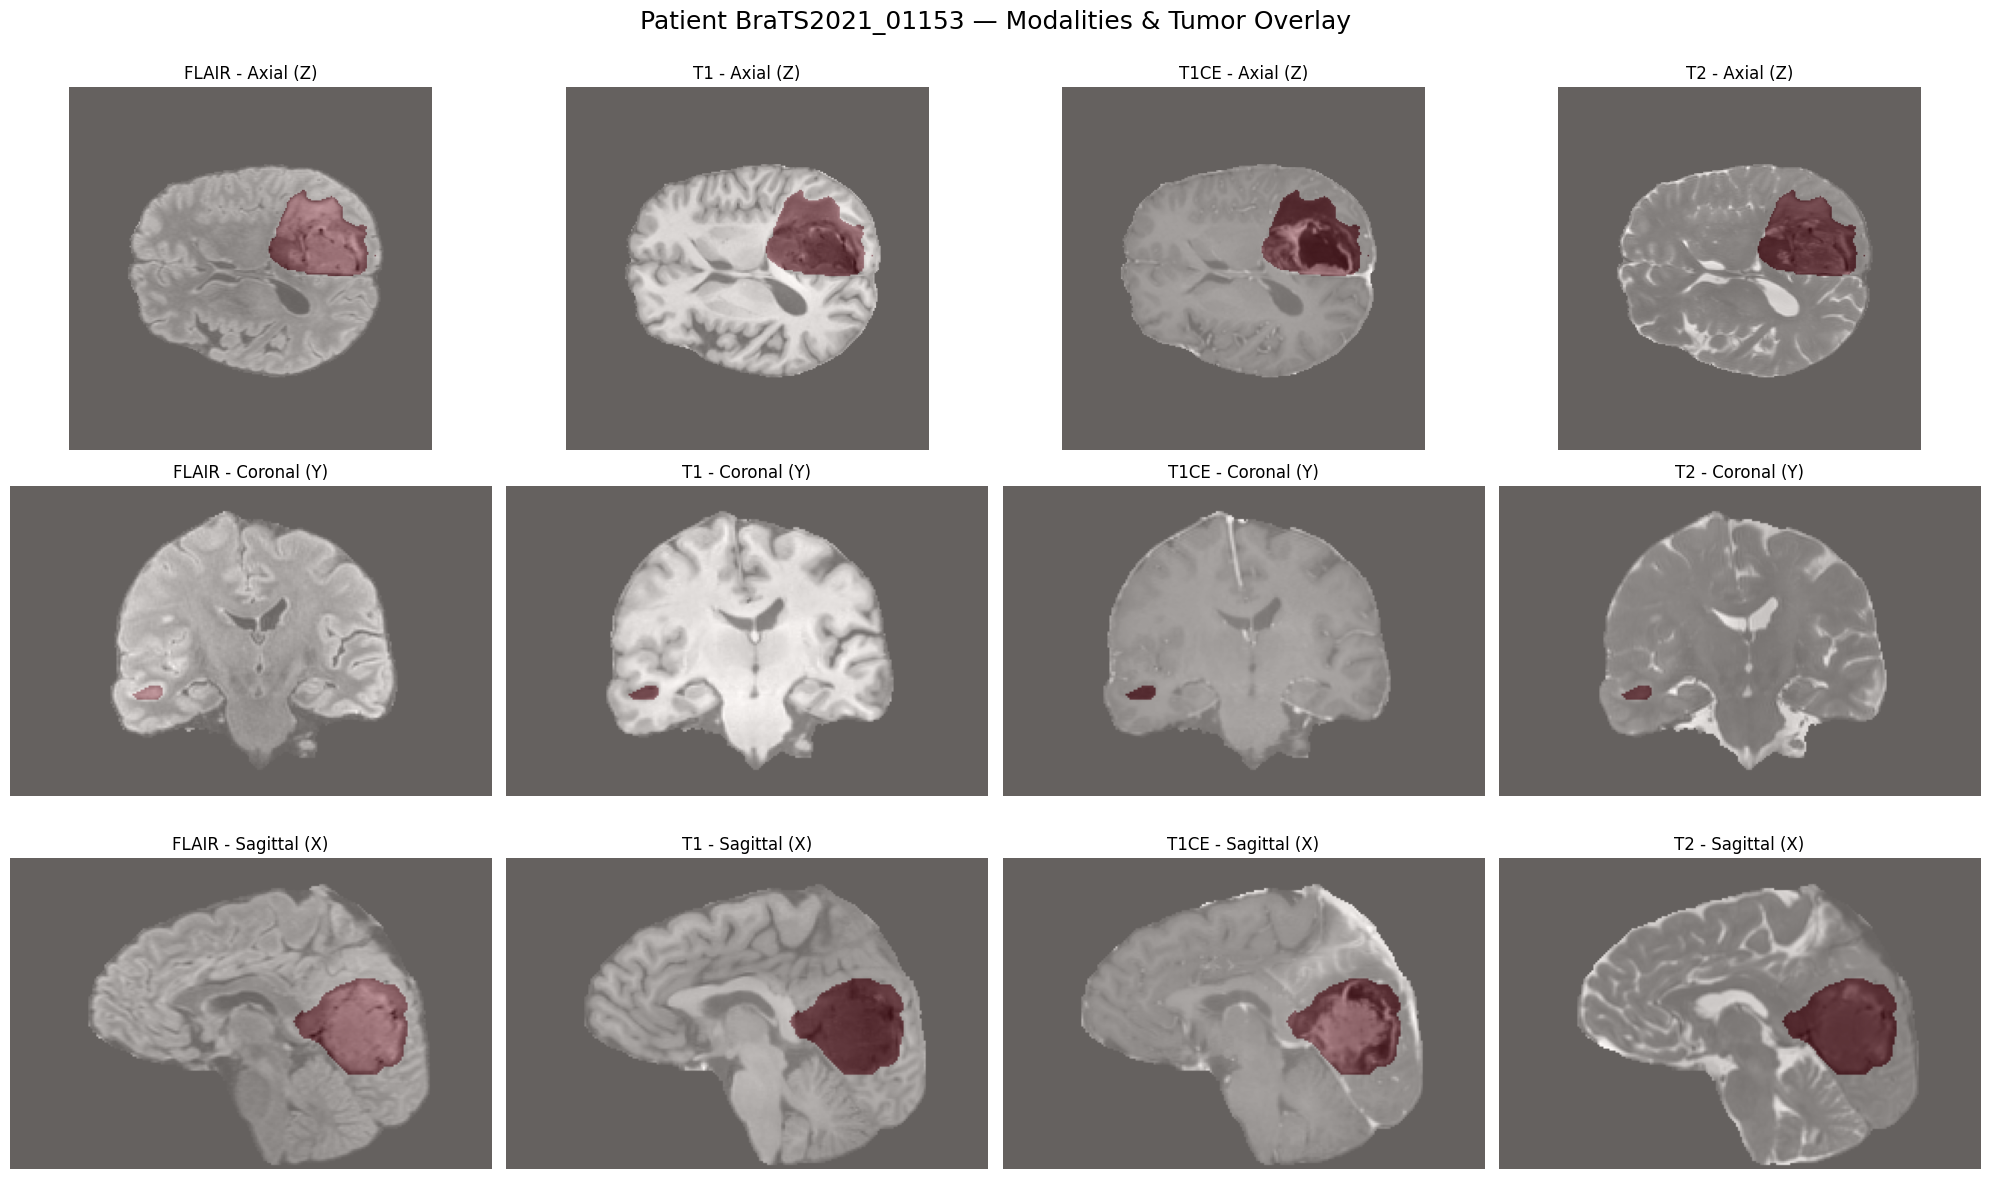

In [128]:
# Pick a random patient
sample_case = random.choice(cases)
modalities = ["flair", "t1", "t1ce", "t2"]
images = {}

# Load all modalities and segmentation
for mod in modalities:
    images[mod] = nib.load(os.path.join(root_dir, sample_case, f"{sample_case}_{mod}.nii.gz")).get_fdata().astype(np.float32)

seg = nib.load(os.path.join(root_dir, sample_case, f"{sample_case}_seg.nii.gz")).get_fdata().astype(np.float32)

# Mid slices
mid_z = seg.shape[2] // 2
mid_y = seg.shape[1] // 2
mid_x = seg.shape[0] // 2

fig, axs = plt.subplots(3, 4, figsize=(20, 12))
fig.suptitle(f"Patient {sample_case} — Modalities & Tumor Overlay", fontsize=18, y=1.0002)

plane_titles = ["Axial (Z)", "Coronal (Y)", "Sagittal (X)"]

for col, mod in enumerate(modalities):
    # Axial
    axs[0, col].imshow(images[mod][:, :, mid_z], cmap='gray')
    axs[0, col].imshow(seg[:, :, mid_z] > 0, alpha=0.4, cmap='Reds')
    axs[0, col].set_title(f"{mod.upper()} - {plane_titles[0]}")
    axs[0, col].axis("off")
    
    # Coronal
    axs[1, col].imshow(np.flipud(images[mod][:, mid_y, :].T), cmap='gray')
    axs[1, col].imshow(np.flipud((seg[:, mid_y, :] > 0).T), alpha=0.4, cmap='Reds')
    axs[1, col].set_title(f"{mod.upper()} - {plane_titles[1]}")
    axs[1, col].axis("off")

    # Sagittal
    axs[2, col].imshow(np.flipud(images[mod][mid_x, :, :].T), cmap='gray')
    axs[2, col].imshow(np.flipud((seg[mid_x, :, :] > 0).T), alpha=0.4, cmap='Reds')
    axs[2, col].set_title(f"{mod.upper()} - {plane_titles[2]}")
    axs[2, col].axis("off")


plt.tight_layout()
plt.show()


### 4. 3D Dataset Characteristics

In [13]:
cases = sorted([
    c for c in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, c)) and not c.startswith(".")
])

shapes = []
zooms = []

for case in cases:
    path = os.path.join(root, case, f"{case}_flair.nii.gz")
    img = nib.load(path)
    
    shapes.append(img.shape)
    zooms.append(img.header.get_zooms())

print("Unique shapes:", set(shapes))
print("Unique voxel spacings:", set(zooms))


Unique shapes: {(240, 240, 155)}
Unique voxel spacings: {(1.0, 1.0, 1.0)}


In [14]:
tumor_volumes = []
brain_volumes = []

for case in cases:
    seg = nib.load(os.path.join(root_dir, case, f"{case}_seg.nii.gz")).get_fdata()
    spacing = nib.load(os.path.join(root_dir, case, f"{case}_seg.nii.gz")).header.get_zooms()
    voxel_volume = np.prod(spacing)
    
    tumor_voxels = np.sum(seg > 0)
    brain_voxels = np.prod(seg.shape)
    
    tumor_volumes.append(tumor_voxels * voxel_volume)
    brain_volumes.append(brain_voxels * voxel_volume)

print("Min tumor volume (ml):", np.min(tumor_volumes) / 1000)
print("Max tumor volume (ml):", np.max(tumor_volumes) / 1000)
print("Median (ml):", np.median(tumor_volumes) / 1000)


Min tumor volume (ml): 2.808
Max tumor volume (ml): 361.783
Median (ml): 89.335


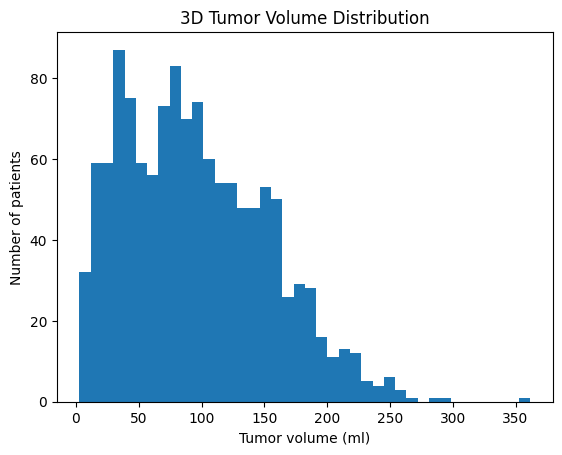

In [15]:
plt.hist(np.array(tumor_volumes)/1000, bins=40)
plt.xlabel("Tumor volume (ml)")
plt.ylabel("Number of patients")
plt.title("3D Tumor Volume Distribution")
plt.show()

In [26]:
tumor_ratio = np.sum(tumor_volumes) / np.sum(brain_volumes)
print(f"Tumor occupies {tumor_ratio*100:.3f}% of all voxels")

Tumor occupies 1.075% of all voxels


### 5. Tumor Subregions

In [77]:
import pandas as pd

# Define labels in BraTS segmentation
labels = [0, 1, 2, 4]
label_names = {
    0: "Background",
    1: "Necrotic/Non-enhancing core",
    2: "Edema",
    4: "Enhancing tumor"
}

total_voxels = {l: 0 for l in labels}
patients_with_label = {l: 0 for l in labels}

for case in cases:
    seg = nib.load(os.path.join(root_dir, case, f"{case}_seg.nii.gz")).get_fdata().astype(np.int16)
    for l in labels:
        vox_count = np.sum(seg == l)
        total_voxels[l] += vox_count
        if vox_count > 0:
            patients_with_label[l] += 1

all_voxels = sum(total_voxels.values())

# Build DataFrame
df = pd.DataFrame({
    "Label": labels,
    "Region": [label_names[l] for l in labels],
    "Voxels": [total_voxels[l] for l in labels],
    "Share, %": [100 * total_voxels[l] / all_voxels for l in labels],
    "Patients with label": [patients_with_label[l] for l in labels]
})

pd.set_option('display.float_format', lambda x: '%.4f' % x)
print(df)


   Label                       Region       Voxels  Share, %  \
0      0                   Background  11048872504   98.9251   
1      1  Necrotic/Non-enhancing core     17896396    0.1602   
2      2                        Edema     75328509    0.6744   
3      4              Enhancing tumor     26830591    0.2402   

   Patients with label  
0                 1251  
1                 1208  
2                 1250  
3                 1218  


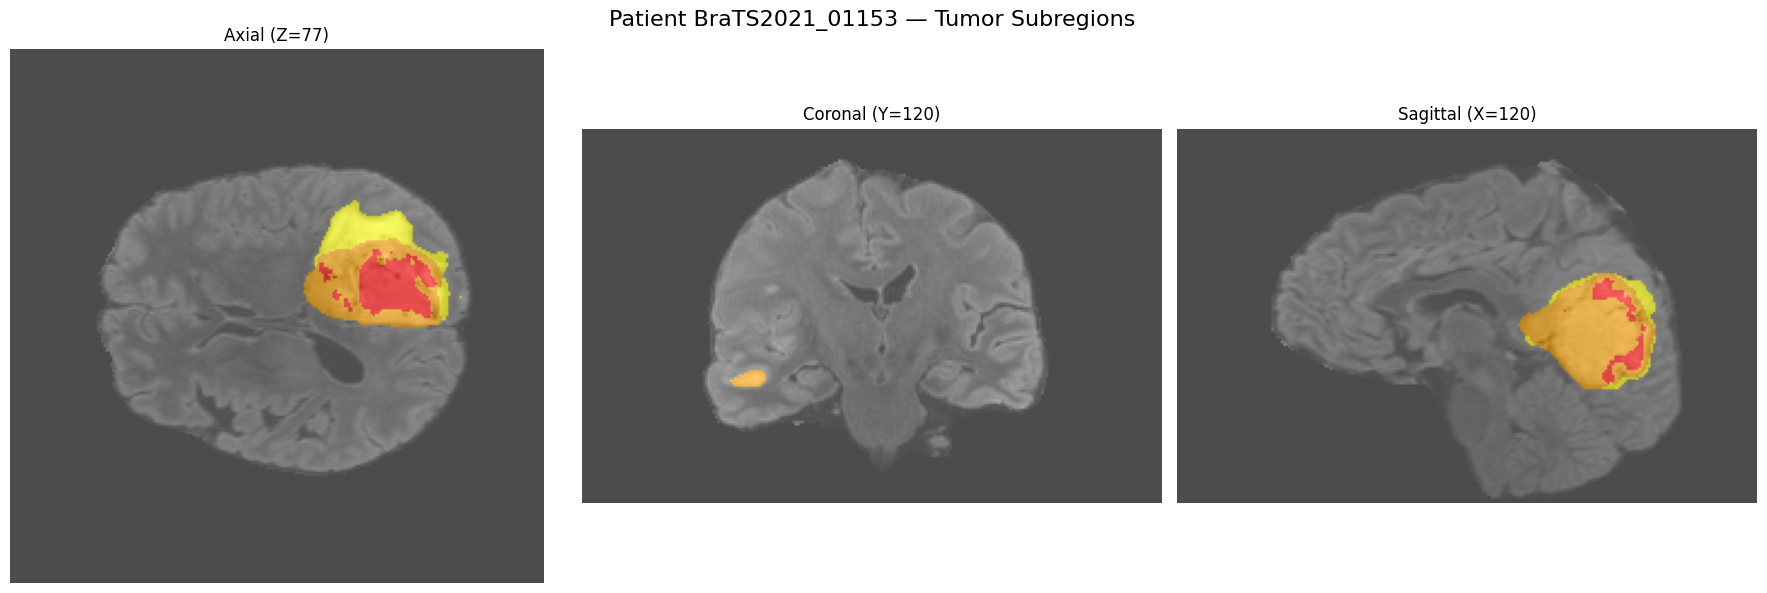

In [129]:
from matplotlib.colors import ListedColormap

# Pick a slice index (for axial view)
mid_z = seg.shape[2] // 2
mid_y = seg.shape[1] // 2
mid_x = seg.shape[0] // 2

# Define colors for background, necrotic, edema, enhancing
colors = ["gray", "red", "yellow", "orange"]  # 0 = background
cmap = ListedColormap(colors)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"Patient {sample_case} — Tumor Subregions", fontsize=16)

# Axial (Z)
axs[0].imshow(images["flair"][:, :, mid_z], cmap="gray")
axs[0].imshow(seg[:, :, mid_z], cmap=cmap, alpha=0.6)
axs[0].set_title(f"Axial (Z={mid_z})")
axs[0].axis("off")

# Coronal (Y)
axs[1].imshow(np.flipud(images["flair"][:, mid_y, :].T), cmap="gray")
axs[1].imshow(np.flipud(seg[:, mid_y, :].T), cmap=cmap, alpha=0.6)
axs[1].set_title(f"Coronal (Y={mid_y})")
axs[1].axis("off")

# Sagittal (X)
axs[2].imshow(np.flipud(images["flair"][mid_x, :, :].T), cmap="gray")
axs[2].imshow(np.flipud(seg[mid_x, :, :].T), cmap=cmap, alpha=0.6)
axs[2].set_title(f"Sagittal (X={mid_x})")
axs[2].axis("off")

plt.tight_layout()
plt.show()
